# Milestone 2 - Hypothesis Simulation 

## Eowyn Baughman - Student name



## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap and Bayesian methods
3. Compute confidence intervals for the above summary statistics by classical, bootstrap and  Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model
            
**Grading Rubric:**
1. Distribution and statistics
  *  Uses classical, bootstrap, and Bayesian methods
2. Confidence intervals
  * Classical, bootstrap, and Bayes methods
3. Hypothesis tests
  * Classical, Tukey, bootstrap, and Bayes model
4. New relationships explored
  * 2+ attributes NOT fuel type, aspiration, drive-wheels, body style

### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [93]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [94]:
# Load necessary libraries
import pandas as pd
import scipy.stats as ss
import numpy.random as nr
import statsmodels.stats.weightstats as ws
import numpy as np
from scipy.stats import kstest
from sklearn.preprocessing import scale
import sklearn.preprocessing as sp
from scipy import stats
import statsmodels.stats.weightstats as ws
import matplotlib.pyplot as plt
from statistics import mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from operator import add
import scipy

** Preamble **

This assignment was enormous. Between the various permutations in methods, features, statistics, and categories, I counted at least 60 separate "things" one had to solve to meet the requirements of the grading rubric, not including any narative, markdown, or figures, and not including cleaning the data and doing feature selection. There was significant ambiguity in terms of how many features/categories/stats which Yusuf addressed in canvas threads, inbox replies, and in-class answers. I've noted in my markdown where something was informed by something he said. I have done my level best, during almost three weeks of working on this, to meet every single requirement. I hope I got them all, and the narrative makes sense overall. 

In [95]:
## Read the data into pandas data frame

# Read data into pandas dataframe using function provided in class, modified to remove '?' from all cols where it exists
# This involves recasting the num-doors from "two", "four", "?" to 2,4,'?'
def read_auto_data(fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"):
    'Function to load the auto price data set from a .csv file' 
    import pandas as pd
    import numpy as np

    ## Read the .csv file with the pandas read_csv method
    auto_price = pd.read_csv(fileName)
    
    ## Recast num-doors to integers to remove the '?' rows
    auto_price.loc[auto_price['num-of-doors'] == 'four', 'num-of-doors'] = 4
    auto_price.loc[auto_price['num-of-doors'] == 'two', 'num-of-doors'] = 2

    ## Remove rows with missing values, accounting for mising values coded as '?'
    cols = ['price', 'bore', 'stroke', 'num-of-doors',
          'horsepower', 'peak-rpm', 'normalized-losses']
    for column in cols:
        auto_price.loc[auto_price[column] == '?', column] = np.nan
    auto_price.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_price[column] = pd.to_numeric(auto_price[column])
        
    return auto_price

# Read autoprice and keep just the relevant columns
auto_price = read_auto_data()
print(auto_price.head(n=2))

   symboling  normalized-losses  make fuel-type aspiration  num-of-doors  \
3          2                164  audi       gas        std             4   
4          2                164  audi       gas        std             4   

  body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
3      sedan          fwd           front        99.8  ...            109   
4      sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compression-ratio horsepower  peak-rpm city-mpg  \
3         mpfi  3.19     3.4              10.0        102      5500       24   
4         mpfi  3.19     3.4               8.0        115      5500       18   

   highway-mpg  price  
3           30  13950  
4           22  17450  

[2 rows x 26 columns]


In [96]:
# Check out the data: ensure no Null data
print(auto_price.info())

# Create a function to collect the column names for the various data types present
def collect_columns_by_type(df):
    strcols = []
    numcols = []
    for column in list(df):
        if (df.loc[:,""+column].dtype == 'int64') | (df.loc[:,""+column].dtype == 'float64'):
            numcols.append(column)
        elif df.loc[:,""+column].dtype == 'object':
            strcols.append(column)
        else:
            print('some other type: {}'.format(auto_price.loc[:,""+column].dtype))
    return (strcols, numcols)

strcols, numcols = collect_columns_by_type(auto_price)
print("Numeric columns: {}".format(numcols))
print("String/object columns: {}".format(strcols))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
symboling            159 non-null int64
normalized-losses    159 non-null int64
make                 159 non-null object
fuel-type            159 non-null object
aspiration           159 non-null object
num-of-doors         159 non-null int64
body-style           159 non-null object
drive-wheels         159 non-null object
engine-location      159 non-null object
wheel-base           159 non-null float64
length               159 non-null float64
width                159 non-null float64
height               159 non-null float64
curb-weight          159 non-null int64
engine-type          159 non-null object
num-of-cylinders     159 non-null object
engine-size          159 non-null int64
fuel-system          159 non-null object
bore                 159 non-null float64
stroke               159 non-null float64
compression-ratio    159 non-null float64
horsepower           159 non-nul

In [97]:
# Check out the unique values, which will also show '?' if present. This is how I found the ? in num-of-doors!
for column in strcols:
    print("Unique values of {}: {}".format(column, auto_price.loc[:,""+column].unique()))

#for column in intcols:
#    print("Unique values of {}: {}".format(column, auto_price.loc[:,""+column].unique()))

Unique values of make: ['audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'jaguar' 'mazda' 'mercedes-benz'
 'mitsubishi' 'nissan' 'peugot' 'plymouth' 'porsche' 'saab' 'subaru'
 'toyota' 'volkswagen' 'volvo']
Unique values of fuel-type: ['gas' 'diesel']
Unique values of aspiration: ['std' 'turbo']
Unique values of body-style: ['sedan' 'hatchback' 'wagon' 'hardtop' 'convertible']
Unique values of drive-wheels: ['fwd' '4wd' 'rwd']
Unique values of engine-location: ['front']
Unique values of engine-type: ['ohc' 'l' 'dohc' 'ohcv' 'ohcf']
Unique values of num-of-cylinders: ['four' 'five' 'six' 'three' 'eight']
Unique values of fuel-system: ['mpfi' '2bbl' 'mfi' '1bbl' 'idi' 'spdi']


Engine-location only has one unique value, so we won't bother exploring along that axis. We've done a lot with fuel-type and aspiration already, and some work with drive-wheels and body-style, so I think we should not focus on these, either. Let's explore efficiency in terms of city-mpg and highway-mpg; we may end up taking an average of these if they're well-correlated. How does efficiency depend on the following: curb-weight, engine-size, price (all numerics), engine-type, num-of-cylinders (categorical)?

I'm also interested in the car maker, but there are lots of them; what about their countries of origin (determined by headquarters) ? There is 1 French car, 1 UK car, 2 Swedish cars, 3 American cars,  5 German cars, and 6 Japanese cars. Reducing the categories from 18 to 5 (possibly 3, if there are very few french & UK cars) would make it a lot easier to analyze, and possibly more informative, so I'm going to do that in order to include "make-origin" as a feature.

['audi - german' 'bmw - german' 'chevrolet - usa' 'dodge - usa' 'honda - japan' 'jaguar - uk' 'mazda - japan' 'mercedes-benz - german'
 'mitsubishi - japan' 'nissan - japan' 'peugot - french' 'plymouth - usa' 'porsche - german' 'saab - sweden' 'subaru - japan'
 'toyota - japan' 'volkswagen - german' 'volvo - sweden']

In [98]:
# Recode cars by their company's country of origin
auto_price.loc[auto_price['make'] == 'peugot', 'make-origin'] = 'france'
auto_price.loc[auto_price['make'] == 'jaguar', 'make-origin'] = 'uk'
auto_price.loc[(auto_price['make'] == 'saab') | (auto_price['make'] == 'volvo') , 'make-origin'] = 'sweden'
auto_price.loc[(auto_price['make'] == 'chevrolet') | (auto_price['make'] == 'dodge') | (auto_price['make'] == 'plymouth') 
               , 'make-origin'] = 'usa'
auto_price.loc[(auto_price['make'] == 'audi') | (auto_price['make'] == 'bmw') | (auto_price['make'] == 'mercedes-benz') |
               (auto_price['make'] == 'porsche') | (auto_price['make'] == 'volkswagen') , 'make-origin'] = 'germany'
auto_price.loc[(auto_price['make'] == 'honda') | (auto_price['make'] == 'mazda') | (auto_price['make'] == 'mitsubishi') |
               (auto_price['make'] == 'nissan') | (auto_price['make'] == 'subaru') | (auto_price['make'] == 'toyota') 
               , 'make-origin'] = 'japan'
assert (auto_price.loc[(auto_price['make-origin'] != 'japan') & (auto_price['make-origin'] != 'usa') &
                     (auto_price['make-origin'] != 'sweden') & (auto_price['make-origin'] != 'france') &
                     (auto_price['make-origin'] != 'germany') & (auto_price['make-origin'] != 'uk'), "make"]).empty

In [99]:
# Check the correlation on the mpg variables
print(auto_price.loc[:, ["city-mpg","highway-mpg"]].corr())

# As suspected, they're highly correlated, so let's create a new column representing their average:
auto_price["mpg"] = auto_price.loc[:, ["city-mpg","highway-mpg"]].mean(axis=1)
print(auto_price.loc[:, ["city-mpg","highway-mpg","mpg"]].head())

             city-mpg  highway-mpg
city-mpg     1.000000     0.971999
highway-mpg  0.971999     1.000000
    city-mpg  highway-mpg   mpg
3         24           30  27.0
4         18           22  20.0
6         19           25  22.0
8         17           20  18.5
10        23           29  26.0


In [100]:
# What are the correlations between mpg and all the other variables?
print(auto_price.corr()['mpg'][:-1])

symboling            0.121411
normalized-losses   -0.212861
num-of-doors        -0.164433
wheel-base          -0.600869
length              -0.729694
width               -0.685205
height              -0.214825
curb-weight         -0.781625
engine-size         -0.711829
bore                -0.594826
stroke              -0.016508
compression-ratio    0.250848
horsepower          -0.838328
peak-rpm            -0.042863
city-mpg             0.992563
highway-mpg          0.993376
price               -0.711577
Name: mpg, dtype: float64


In [101]:
# Subset the dataframe to reduce it to the variables we will be exploring
cols = ['mpg', 'curb-weight', 'price', 'engine-size', 'engine-type', 'num-of-cylinders', 'make-origin']
auto_price = auto_price[cols]
print(auto_price.head(n=3))

    mpg  curb-weight  price  engine-size engine-type num-of-cylinders  \
3  27.0         2337  13950          109         ohc             four   
4  20.0         2824  17450          136         ohc             five   
6  22.0         2844  17710          136         ohc             five   

  make-origin  
3     germany  
4     germany  
6     germany  


In [102]:
# Any obvious correlations in our numerics?
print(auto_price.corr())

                  mpg  curb-weight     price  engine-size
mpg          1.000000    -0.781625 -0.711577    -0.711829
curb-weight -0.781625     1.000000  0.893639     0.888626
price       -0.711577     0.893639  1.000000     0.841496
engine-size -0.711829     0.888626  0.841496     1.000000


There are fairly sizable correlations among the different variables. We would not want to include pairs of these variables in a regression analysis.

** Part one: Identify a likely distribution for price and several other features**

Numeric columns: ['mpg', 'curb-weight', 'price', 'engine-size']
String/object columns: ['engine-type', 'num-of-cylinders', 'make-origin']


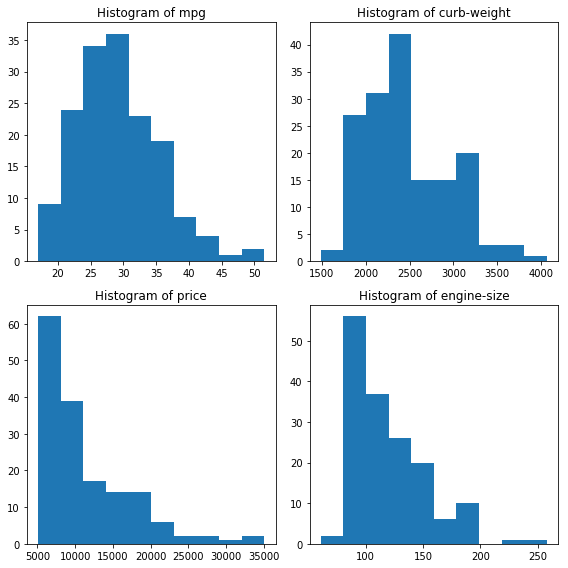

In [103]:
# Collect column names by type for plotting and analysis
strcols, numcols = collect_columns_by_type(auto_price)
print("Numeric columns: {}".format(numcols))
print("String/object columns: {}".format(strcols))

# Function to plot histogram of several variables
def subplot_hist(df, cols):
    %matplotlib inline
    fig = plt.figure(figsize=(8, 8)) # define figure
    nplot = 221
    for var in cols:
        fig.add_subplot(nplot) ## setup the subplot
        plt.hist(df.loc[:,""+var]) ## Plot the subplot
        fig.gca().set_title("Histogram of {}".format(var))  # Give each subplot a title; MUST be done just like so
        nplot += 1
    plt.tight_layout()
    plt.show()

subplot_hist(auto_price, numcols)

MPG looks normal, curb weight, and price look normal-ish. I will test their distributions, and also the log of those values, as often the log of something looks more normal than the thing itself.

log-mpg vs norm has KS-stat: 0.087677 and P-value: 16.353715% with args []
log-curb-weight vs norm has KS-stat: 0.103151 and P-value: 6.312373% with args []
log-price vs norm has KS-stat: 0.119748 and P-value: 1.915463% with args []
log-engine-size vs norm has KS-stat: 0.156004 and P-value: 0.075992% with args []


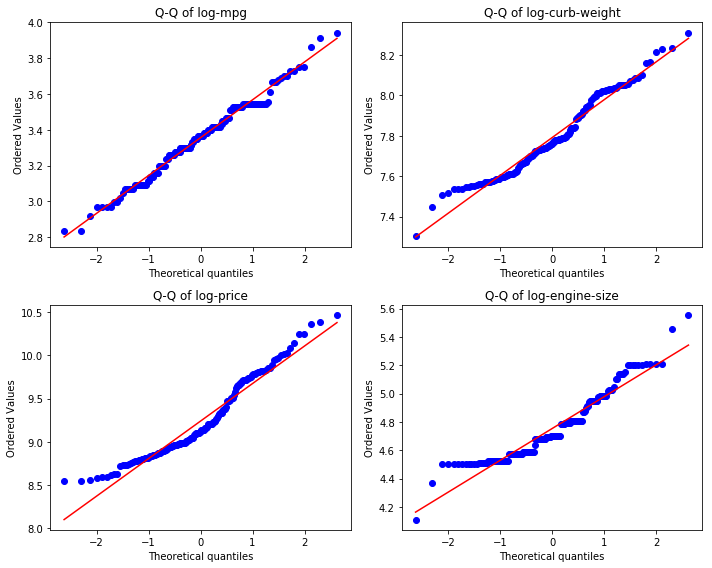

mpg vs norm has KS-stat: 0.100821 and P-value: 7.357506% with args []
curb-weight vs norm has KS-stat: 0.140044 and P-value: 0.349619% with args []
price vs norm has KS-stat: 0.190859 and P-value: 0.001514% with args []
engine-size vs norm has KS-stat: 0.186881 and P-value: 0.002465% with args []


C:\Users\eowyn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


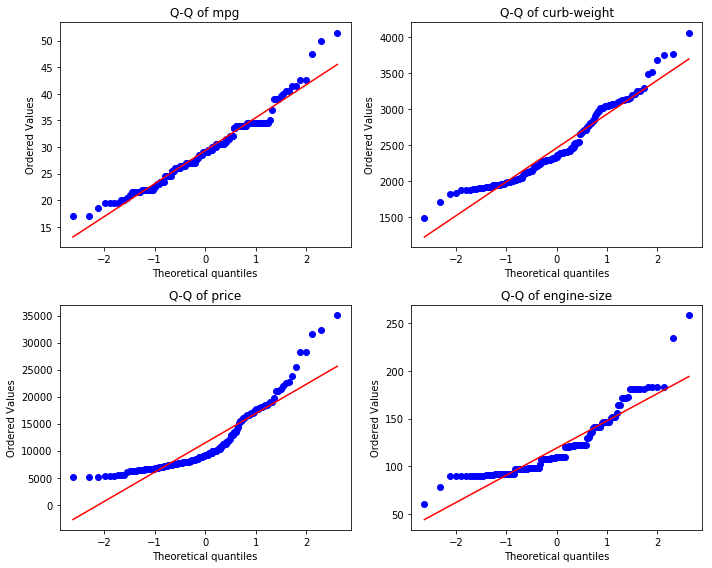

In [104]:
# Create a function to calcuate Kolmogorov Smirnov stats for distribution against several options
# Recall that kstest must operate on scaled/normalized data
def ks_test(df, cols, args = [], dist = 'norm', log = False):
    from scipy.stats import kstest 
    from sklearn.preprocessing import scale
    for var in cols:
        if log:
            x = np.log(df.loc[:,""+var])
            var = 'log-' + var
        else:
            x = df.loc[:,""+var]
        ks_stat, pvalue = kstest(scale(x), dist, args)
        print("{} vs {} has KS-stat: {:2f} and P-value: {:2%} with args {}".format(var, dist, ks_stat, pvalue, args))

# Plot the quantiles. Scipy's probplot method plots against the standard normal by default
def plot_qq(df, cols, ddist = 'norm', args = (), log = False):
    %matplotlib inline
    fig = plt.figure(figsize=(10, 8)) # define figure
    nplot = 221
    for var in cols:
        fig.add_subplot(nplot) ## setup the left subplot
        if log:
            x = np.log(df.loc[:,""+var])
            var = 'log-' + var
        else:
            x = df.loc[:,""+var]
        ss.probplot(x, plot = fig.gca(), dist = ddist, sparams = args) ## Plot the left subplot
        fig.gca().set_title("Q-Q of {}".format(var))  # Give each subplot a title; MUST be done just like so
        nplot += 1
    plt.tight_layout()
    plt.show()
    
ks_test(auto_price, numcols, log = True)
plot_qq(auto_price, numcols, log = True)
ks_test(auto_price, numcols, log = False)
plot_qq(auto_price, numcols, log = False)

Interpretting the prob plots and K-S and P-vals is a bit tricky so let's be clear: the sigma level is 0.05 (5%) on a hypothesis "the distribution of the data is normal". So a p-val > 5% means "cannot reject the null hypothesis" which isn't to say it is definitely normal, but that plus a Q-Q plot that falls along a 1:1 line is good indication that the normal distribution is a good representation of the data. From these, we can say that MPG and log-Curb-Weight are normally distributed, but price and engine size are not well represented by the normal distribution (or their log forms). I will try to fit other forms of distributions for these variables.  

price vs weibull_min has KS-stat: 0.076651 and P-value: 29.340642% with args [1.0979788466790135, -1.080999115545888, 1.1202913711948521]


C:\Users\eowyn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


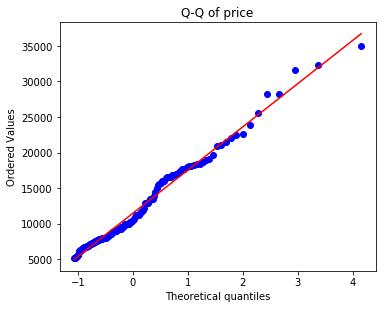

In [105]:
# Fit a weibull to price and engine size
from scipy.stats import weibull_min
a, b, c = weibull_min.fit(sp.scale(auto_price.loc[:,'price']))
ks_test(auto_price, ["price"], args = [a, b, c], dist = 'weibull_min', log = False)
plot_qq(auto_price, ["price"], ddist = 'weibull_min', args = (a,b,c), log = False)


OK! We fit a Weibull distribution to the price data and the K-S resulting p-value suggests the distribution is not statistically different from the fitted Weibull. 

Now the last variable to fit is engine size. We will try several forms.

C:\Users\eowyn\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


engine-size vs weibull_min has KS-stat: 0.498305 and P-value: 0.000000% with args [0.96095965262398253, -1.9175596842200959, 1.3537610286443513]


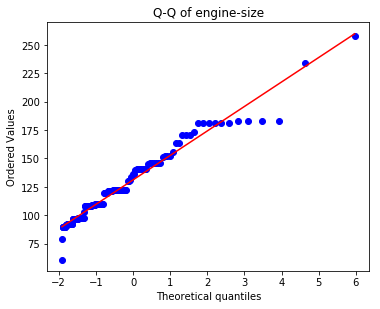

C:\Users\eowyn\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:412: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


engine-size vs beta has KS-stat: 0.139509 and P-value: 0.366912% with args [4.2405799838351133, 4235772.4190568067, -2.0390724354074981, 2064681.4822225263]


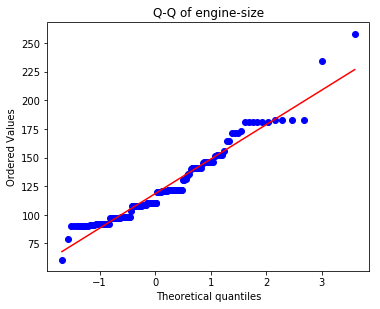

engine-size vs gamma has KS-stat: 0.143435 and P-value: 0.256350% with args [5.1586246706090355, -2.1089293382375516, 0.40881511043171737]


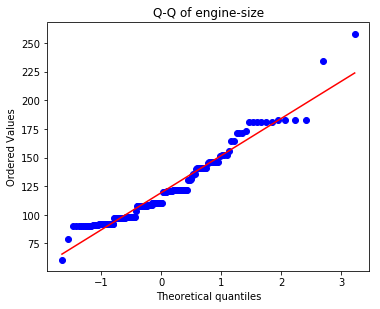

engine-size vs rayleigh has KS-stat: 0.171191 and P-value: 0.015228% with args [-1.9500668176582998, 1.5496624783669657]


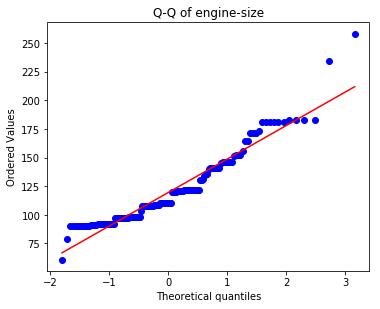

In [106]:
a, b, c = weibull_min.fit(sp.scale(auto_price.loc[:,'engine-size']))
ks_test(auto_price, ["engine-size"], args = [a, b, c], dist = 'weibull_min', log = False)
plot_qq(auto_price, ["engine-size"], ddist = 'weibull_min', args = (a,b,c), log = False)

from scipy.stats import beta
a, b, c, d = beta.fit(sp.scale(auto_price.loc[:,'engine-size']))
ks_test(auto_price, ["engine-size"], args = [a, b, c, d], dist = 'beta', log = False)
plot_qq(auto_price, ["engine-size"], ddist = 'beta', args = (a,b,c,d), log = False)

from scipy.stats import gamma
a, b, c = gamma.fit(sp.scale(auto_price.loc[:, 'engine-size']))
ks_test(auto_price, ["engine-size"], args = [a, b, c], dist = 'gamma', log = False)
plot_qq(auto_price, ["engine-size"], ddist = 'gamma', args = (a,b,c), log = False)


from scipy.stats import rayleigh
a, b = rayleigh.fit(sp.scale(auto_price.loc[:, 'engine-size']))
ks_test(auto_price, ["engine-size"], args = [a, b], dist = 'rayleigh', log = False)
plot_qq(auto_price, ["engine-size"], ddist = 'rayleigh', args = (a,b), log = False)

I cannot find a fitted distribution that is a good representation for engine-size. I'm going to drop it; it is pretty well correlated with curb-weight, anyway, and that we do have a good distribtion fitted for.

In [107]:
# Drop the engine size column, and go ahead and reset the index
auto_price.drop(['engine-size'], axis = 1, inplace = True)
numcols.remove('engine-size')
auto_price.reset_index(inplace = True)
auto_price.head()

,index,mpg,curb-weight,price,engine-type,num-of-cylinders,make-origin
0,3,27.0,2337,13950,ohc,four,germany
1,4,20.0,2824,17450,ohc,five,germany
2,6,22.0,2844,17710,ohc,five,germany
3,8,18.5,3086,23875,ohc,five,germany
4,10,26.0,2395,16430,ohc,four,germany


** Part two: Compute basic summary statistics by both classical, bootstrap and Bayesian methods **

For the sake of simplicity, I am defining "summary statistics" to include mean and standard deviation only.

In [108]:
# Classical summary statistics: these are easy built-ins. Record the results as a series to put in a table later.
classical_aves = auto_price.mean(axis=0)[1:] # don't include index
classical_stds = auto_price.std(axis=0)[1:] # don't include index
print("The classical averages are:\n {}".format(classical_aves))
print("The classical stdevs are:\n {}".format(classical_stds))

The classical averages are:
 mpg               29.301887
curb-weight     2461.138365
price          11445.729560
dtype: float64
The classical stdevs are:
 mpg               6.234098
curb-weight     481.941321
price          5877.856195
dtype: float64


In [109]:
# More summary stats: This is easy so let's get a bigger set of classical statistics
print(auto_price.describe())

            index         mpg  curb-weight         price
count  159.000000  159.000000   159.000000    159.000000
mean   109.044025   29.301887  2461.138365  11445.729560
std     58.413123    6.234098   481.941321   5877.856195
min      3.000000   17.000000  1488.000000   5118.000000
25%     60.500000   25.000000  2065.500000   7372.000000
50%    111.000000   29.000000  2340.000000   9233.000000
75%    159.500000   34.000000  2809.500000  14719.500000
max    204.000000   51.500000  4066.000000  35056.000000


In [110]:
# Bootstrap summary statistics: Calculate the classical mean, but on a whole bunch of 
# samples created by sampling, with replacement, from the original distribution. 

# a function to calculate and print the means and standard deviations using Bootstrapping
def calc_bootstrap_stats(df, cols, n_replicas = 1000):
    bs_stats = pd.DataFrame() # empty dataframe to store results 
    for var in cols:
        x = df.loc[:,""+var]
        bootstrap_means = pd.Series([x.sample(frac=1, replace=True).mean() for i in range(n_replicas)])
        bootstrap_stds = pd.Series([x.sample(frac=1, replace=True).std() for i in range(n_replicas)])
        bs_stats.loc[""+var, "BS Mean"] = bootstrap_means.mean()
        bs_stats.loc[""+var, "BS StD"] = bootstrap_means.std()
    return bs_stats

df = calc_bootstrap_stats(auto_price, numcols)
print(df)

                  BS Mean      BS StD
mpg             29.328434    0.484639
curb-weight   2460.385220   38.689766
price        11422.704862  469.989318


**Bayesian Summary Statistics**
1. Need to choose a prior: We fit distributions, so let's try to use conjugate-priors
    * For mpg and log-curb-weight (normally distributed), conj prior is normal or inverse normal
    * For price (weibull distribution, params fitted), conj prior is not precisely solved for, but good approximations exist in the form of inverse gamma functions (see https://www.johndcook.com/CompendiumOfConjugatePriors.pdf p.21, which also gives a form of a likelihood function)
    * Yusuf told me in class that implementing the weibull solution would be "beyond the scope of this assignment" but for completion I do need to do the price-variable, so I will be using a Normal form for the log-price, similar to curb-weight
2. Need to calculate the likelihood function: provided in class for the normal, and in that paper for the inverse gamma
3. Need to calculate the posterior distribution, and find its mean/std: which is simple once you have the prior and likelihood


In [111]:
# NORMALLY DISTRIBUTED VARIABLES: MPG and log-Curb-weight and log-price

# likelihood function for gaussian variables. x should be the binned variable, 
def comp_like_gauss(p, x, islog = False): 
    import numpy as np
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

# function to create posterior distributonon give prior and likelihood function
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

# Baysian Credible Interval, which is not quite the same as a confidence interval, but is the closest analog
def print_ci(p, post, num_samples = 1000, lower_q = 0.025, upper_q = 0.975, islog = False):
    import scipy
    from matplotlib import pyplot
    import numpy as np
    ## This function computes a credible interval using an assumption
    ## of symmetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    # p: parameter space values 
    # post: posterior distribution
    # num_samples: number of samples to generate from p
    # lower_q: lower percentile of range
    # upper_q: upper percentile of range
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    interval = upper_q - lower_q
    if islog:
        print('The {:.3f} credible interval is {:.3f} to {:.3f}'.format(interval, np.exp(ci[0]), np.exp(ci[1])))
    else:
        print('The %.3f credible interval is %.3f to %.3f' % (interval, ci[0], ci[1]))
    
# Find and return the mean of a posterior distribution
def bayes_mean(p, post, islog = False):
    # p: parameter space values 
    # post: posterior distribution
    import operator
    import numpy as np
    max_index, max_value = max(enumerate(post), key=operator.itemgetter(1))
    assert post[max_index] == max(post)
    if islog:
        return np.exp(p[max_index])
    else:
        return p[max_index]
                                                                                                                                    

MPG
The 0.950 credible interval is 28.257 to 30.227
The Baysian mean is: 29.294


Text(0.5,1,'MPG: Bayes')

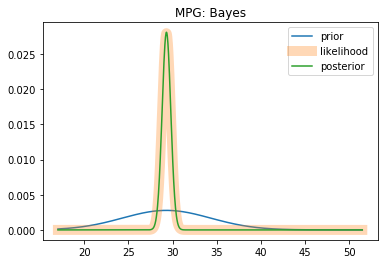

In [112]:
# compute prior, likelihood and posterior. Calculate the Credible Interval (CI) at this time.
# CI only applies to the mean

# First do MPG
vec = auto_price.mpg
print("MPG")

N = 1000
p = np.linspace(min(vec), max(vec), num=N)

# create a prior
# ou prior will look at values around the actual mean with a standard deviation of 5
# visually we can see this is fairly diffuse (less informative prior)
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post)))
plt.plot(p, norm_prior, label='prior')
plt.plot(p, like, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post, label='posterior')
plt.legend()
plt.title("MPG: Bayes")


The Baysian mean of MPG is very similar to the Classical stats result, and very similar to the Bootstrap mean as well. I'm printing the 95% credible interval on the Bayes mean here as well, and we can see that the mean could possibly vary from 28.3 to 30.3 depending on the sampling.

Curb-Weight
The 0.950 credible interval is 2347.278 to 2485.843
The Baysian mean is: 2416.783


Text(0.5,1,'Log-Curb Weight: Bayes')

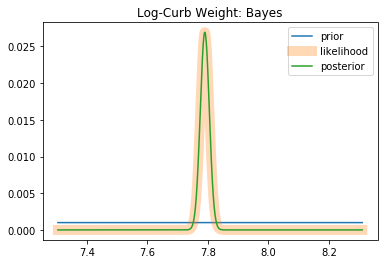

In [113]:
# Next do curb-weight whose log is normally distributed, so do the math on the log form then exponentiate to get final answer.
# My functions that do the printing have "islog" boolean implemented to take care of returning the correct answer.
vec = np.log(auto_price.loc[:,'curb-weight'])
print("Curb-Weight")

N = 1000
p = np.linspace(min(vec), max(vec), num=N)

# create a prior
# ou prior will look at values around the actual mean with a standard deviation of 5
# visually we can see this is fairly diffuse (less informative prior)
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec, islog = True)
post = posterior(norm_prior, like)
print_ci(p, post, islog = True)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post, islog=True)))
plt.plot(p, norm_prior, label='prior')
plt.plot(p, like, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post, label='posterior')
plt.legend()
plt.title("Log-Curb Weight: Bayes")

The Baysian mean and standard deviation on curb weight are similar but a bit lower realtive to the Classical and Bootstrap means.I'm printing the 95% credible interval on the Bayes mean here as well, and we can see that the mean could possibly vary from 2747:2488 lbs depending on the sampling.

Price
The 0.950 credible interval is 9571.110 to 10994.873
The Baysian mean is: 10297.914


Text(0.5,1,'Log-Price: Bayes')

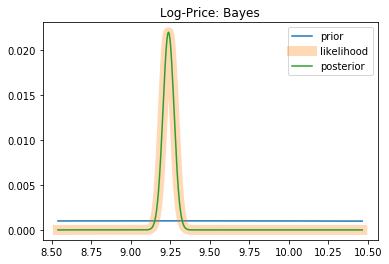

In [114]:
# Finally do price whose log is normally distributed, so do the math on the log form then exponentiate to get final answer.
# My functions that do the printing have "islog" boolean implemented to take care of returning the correct answer.
vec = np.log(auto_price.loc[:,'price'])
print("Price")

N = 1000
p = np.linspace(min(vec), max(vec), num=N)

# create a prior
# ou prior will look at values around the actual mean with a standard deviation of 5
# visually we can see this is fairly diffuse (less informative prior)
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec, islog = True)
post = posterior(norm_prior, like)
print_ci(p, post, islog = True)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post, islog=True)))
plt.plot(p, norm_prior, label='prior')
plt.plot(p, like, label='likelihood', alpha=.3, linewidth=10)
plt.plot(p, post, label='posterior')
plt.legend()
plt.title("Log-Price: Bayes")

The Baysian mean and standard deviation on curb weight are similar but a bit lower realtive to the Classical and Bootstrap means. I'm printing the 95% credible interval on the Bayes mean here as well, and we can see that the mean could possibly vary from 9607 - 10995 $ depending on the sampling.

** Part three: Compute confidence intervals for the above summary statistics by:**
1. classical methods - done
2. bootstrap methods - done
3. Bayesian methods ** - std not done. The CI on mean is presented up above where means, std calculated. Yusuf told me this was sufficient to get full credit.


In [115]:
# Classical Methods

# Helper function to compute the classical confidence bounds on a gaussian standard deviation
def classical_ci_std(vec):
    # To compute the confidence interval on the standard deviation. 
    # Eqn from http://www.milefoot.com/math/stat/ci-variances.htm
    from scipy.stats import chi2
    degf = len(vec) - 1
    variance = np.var(vec)
    lower_chi2, upper_chi2 = chi2.isf(q= alpha/2, df=degf), chi2.isf(q= (1-alpha/2), df=degf)
    ci_low, ci_high = np.sqrt(degf*variance/lower_chi2), np.sqrt(degf*variance/upper_chi2)
    return ci_low, ci_high

print(20*'-' + 'MPG' + 20*'-')
# Classical confidence intervals:  MPG
x = auto_price.mpg
alpha = 0.05 # significance level
half_width = scipy.stats.norm.ppf(1-alpha/2, scale = np.std(x))  # Half the PDF
ci_low, ci_high = x.mean() - half_width,  x.mean() + half_width

print('The classical mean of MPG is %.2f' % x.mean())
print('The classical {}% CI is {:.2f} , {:.2f}'.format(100*(1-alpha), ci_low, ci_high))

ci_low, ci_high = classical_ci_std(x)
print('The classical standard deviation of MPG is %.2f' % np.std(x))
print('The classical {}% CI is {:.2f} , {:.2f}'.format(100*(1-alpha), ci_low, ci_high))

print(20*'-' + 'Curb Weight' + 20*'-')
# Classical confidence intervals:  Curb Weight. The log is normal, so we work on logs and exponentiate for final numbers
x = np.log(auto_price.loc[:,'curb-weight'])
alpha = 0.05 # significance level
half_width = scipy.stats.norm.ppf(1-alpha/2, scale = np.std(x))  # Half the PDF
ci_low, ci_high = x.mean() - half_width,  x.mean() + half_width
ci_low, ci_high = np.exp(ci_low), np.exp(ci_high)
mu = np.exp(x.mean())

print('The classical mean of Curb Weight is %.2f' % mu)
print('The classical {}% CI is {:.2f} ,s {:.2f}'.format(100*(1-alpha), ci_low, ci_high))

ci_low, ci_high = classical_ci_std(np.exp(x))
print('The classical standard deviation of MPG is %.2f' % np.std(np.exp(x)))
print('The classical {}% CI is {:.2f} , {:.2f}'.format(100*(1-alpha), ci_low, ci_high))

--------------------MPG--------------------
The classical mean of MPG is 29.30
The classical 95.0% CI is 17.12 , 41.48
The classical standard deviation of MPG is 6.21
The classical 95.0% CI is 5.60 , 6.98
--------------------Curb Weight--------------------
The classical mean of Curb Weight is 2417.12
The classical 95.0% CI is 1672.43 ,s 3493.39
The classical standard deviation of MPG is 480.42
The classical 95.0% CI is 432.79 , 539.93


In [116]:
# Boostrap Methods
n_replicas = 10000
p = 0.05

print(20*'-' + 'MPG' + 20*'-')
x = auto_price.mpg
bootstrap_means = pd.Series([x.sample(frac=1, replace=True).mean() for i in range(n_replicas)])
print("The CI on bootstrap mean of {} is {:.2f}:{:.2f}".format("MPG", np.percentile(bootstrap_means, p/2.), 
                                                       np.percentile(bootstrap_means, 100-p/2.)))

bootstrap_std = pd.Series([np.std(x.sample(frac=1, replace=True)) for i in range(n_replicas)])
print("The CI on bootstrap stdev of {} is {:.2f}:{:.2f}".format("MPG", np.percentile(bootstrap_std, p/2.), 
                                                        np.percentile(bootstrap_std, 100-p/2.)))

print(20*'-' + 'Curb Weight' + 20*'-')
x = np.log(auto_price.loc[:,"curb-weight"])
bootstrap_means = pd.Series([x.sample(frac=1, replace=True).mean() for i in range(n_replicas)])
print("The CI on bootstrap mean of {} is {:.2f}:{:.2f}".format("Curb-Weight", np.exp(np.percentile(bootstrap_means, p/2.)), 
                                                       np.exp(np.percentile(bootstrap_means, 100-p/2.))))

bootstrap_std = pd.Series([np.std(x.sample(frac=1, replace=True)) for i in range(n_replicas)])
print("The CI on bootstrap stdev of {} is {:.2f}:{:.2f}".format("Curb-Weight", np.exp(np.percentile(bootstrap_std, p/2.)), 
                                                        np.exp(np.percentile(bootstrap_std, 100-p/2.))))

--------------------MPG--------------------
The CI on bootstrap mean of MPG is 27.57:31.04
The CI on bootstrap stdev of MPG is 4.79:7.60
--------------------Curb Weight--------------------
The CI on bootstrap mean of Curb-Weight is 2298.22:2541.56
The CI on bootstrap stdev of Curb-Weight is 1.17:1.24


The 95% confidence intervals on these values indicate that, if had 100 samples drawn from the same underlying population, 95 of the time the mean of those samples would fall between the lower and upper confidence bounds. This concept applies to the classical and bootstrap confidence intervals. The Baysian credible interval is a similar concept. We've done all three estimates for three variables, MPG, curb weight, and price. We did it for mean for the 3 methods and stdev for classical & bootstrap. Generally speaking, the CIs span similar central values, but have different widths/intervals. The bootstrap and Baysian CI are the tightest ie have the narrowest bounds; both methods involve resampling by which we can narrow our expectations for what kinds of stats we expect to see. Notable: the bootstrap had 10x as many resamples as the Bayes but similar if not slightly widder CIs than Baysiean inference. Classical CIs were larger than either of the other two, which makes sense as it is based on only 200 points total.

** Part four: Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:**
For this I am focusing on the differences in terms of MEANS. According to discussions on Canvas and with Yusuf, we do not need to do this for differences in variance. I'd like to if I had time, but unfortunately I do not.

1. Classical tests: Since all my variables are multiple categories, this will be Standard ANOVA
2. Tukey’s Honest Significant Differences (HSD)
3. Bootstrap methods
4. Bayesian model

My thoughts on the bootstrap test of difference of means: My college stats textbook describes a few different ways to do this, including the method of permutation testing. That is not the same as bootstrapping as we've practiced it in this class, because it operates on data without replacement. We haven't really talked about hypothesis testing with bootstrapping in this class. The nearest thing we've discussed is bootstrapping the difference in means of two groups, and determining if the confidence interval of the resulting distribution overlaps the 0.0 mark. So that is what I am going to do.

Yusuf specified that I should "pick two features with two categories and one feature with more than two categories" for this part of the assignment. I will be using MPG as the feature with two and more than two categories, because I'm most interested in fuel efficiecy. To meet the standards of the assignment I will also do price. 

In [117]:
# Remind us what the categorical variables and values are
for column in strcols:
    print("Unique values of {}: {}".format(column, auto_price.loc[:,""+column].unique()))

Unique values of engine-type: ['ohc' 'l' 'dohc' 'ohcv' 'ohcf']
Unique values of num-of-cylinders: ['four' 'five' 'six' 'three' 'eight']
Unique values of make-origin: ['germany' 'usa' 'japan' 'uk' 'france' 'sweden']


In [118]:
# These are our replicas for bootstrapping differences of means, and the alpha value for our CIs|
n_replicas = 10
p = 0.05

In [119]:
# Here we define functions to group the data according to a variable, and to plot baysian credible intervals.

def plot_ci(p, post, num_samples = 10000, lower_q = 0.025, upper_q = 0.975):
    ## This function computes a Baysian credible interval using an assumption
    ## of symmetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    pyplot.title('Posterior density with %.3f credible interval' % interval)
    pyplot.plot(p, post, color='blue')
    pyplot.xlabel('Parameter value')
    pyplot.ylabel('Density')
    pyplot.axvline(x=ci[0], color='red')
    pyplot.axvline(x=ci[1], color='red')
    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, lower_q, upper_q))
    

# Gather up groups of pvar split along all the unique categories of another column. Return a list of series containing
# the grouped data, and also return a list of group-names corresponding to the data (for use in Tukey HSD)

def group_conditioned(column = 'body-style', pvar = 'price'):
    # Return groups and list of data grouped by column
    print('Conditioning on: {}'.format(column))
    choices = auto_price.loc[:,column].unique()

    # Create groups based on these stratifications. USE A DICTIONARY
    d = {}
    groups = []
    valid_choices = []
    for choice in choices:
        x = auto_price.loc[auto_price.loc[:, column] == choice, pvar]  # DATA for this style
        print("{0} entries in {1}".format(len(x), choice))  
        if len(x) < 10:
            print("Not including {} as it has fewer than 10 entries".format(choice))
            continue     
            
        d["{0}".format(choice)] = x # Assign data to dictionary object named for this style
        groups += len(x)* ["{0}".format(choice)]  # Record the groups for these entries to use later
        valid_choices.append(choice)
        
    print("The keys in my dictionary are: " + ','.join([k for k in d.keys()]))        
    result = [d[valid_c] for valid_c in valid_choices]
    return(groups, result)




In [120]:
# MPG
print('*'*20 + "MPG - Fuel Efficiency Analysis" + '*'*20)
pvar = 'mpg'
# Run the classical ANOVA F-Test; Tukey HSD Test; Boostrap difference of means test; and Baysian difference of means test
# Do all four for each variable one at a time

# Engine Type: ANOVA, Tukey HSD, and Boostrap Difference of Means Tests
print(20*'-'+ 'Engine-Type' + 20*'-')
# First, Classical f-test (anova) in which we also create our groups and drop any with two few entries (<10)
groups, d = group_conditioned('engine-type', pvar) 
f_statistic, p_value = ss.f_oneway(*d)  # *d unpacks the list into series for the f_oneway function
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

# Second, do a Tukey HSD test on the groups
df = np.concatenate(d).flatten()
Tukey_HSD = pairwise_tukeyhsd(df, groups)
print(Tukey_HSD)

# Third, bootstrap the difference of means and if the CI encompasses 0, cannot reject null hypothesis
print("Alpha:{}".format(alpha))
bootstrap_diff_means = pd.Series([d[0].sample(frac=1, replace=True).mean() - d[1].sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {}:{}".format("OHC", "OHCF", "MPG",lower_ci, upper_ci))

print('-'*20)
# Fourth, Baysian test to see if CI on pair of variables overlap
N = 1000
vec = d[0]
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Bayes CI on OHC")
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post))) 

vec = d[1]
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Bayes CI on OHCF")
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post))) 

********************MPG - Fuel Efficiency Analysis********************
--------------------Engine-Type--------------------
Conditioning on: engine-type
123 entries in ohc
8 entries in l
Not including l as it has fewer than 10 entries
8 entries in dohc
Not including dohc as it has fewer than 10 entries
8 entries in ohcv
Not including ohcv as it has fewer than 10 entries
12 entries in ohcf
The keys in my dictionary are: ohc,ohcf
F statistic = 1.25059411616
P-value = 0.265454859132
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 ohc    ohcf  -1.9014  -5.2645 1.4617 False 
--------------------------------------------
Alpha:0.05
The CI on bootstrap diff (OHC - OHCF) mean of MPG is 0.658591463414632:3.179846036585366
--------------------
Bayes CI on OHC
The 0.950 credible interval is 29.434 to 31.416
The Baysian mean is: 30.458
Bayes CI on OHCF
The 0.950 credible interval is 26.764 to 30.310
The Bay

The dependence of MPG/fuel efficiency on engine type; we would need more data to determine if there is a significant difference between the two groups. Given this dataset, at the 95% confidence level, we cannot reject the null hypothesis that the two sub populations have the same mean MPG. The classical ANOVA approach supports this: P = 0.26, no rejection of a null hypothesis. When we use the Tukey test, it is the same result. Likewise when we bootstrap the difference of means, the confidence interval is  spanning zero. Finally in the Baysian analysis, the credible interval on the two groups have considerable intersection; cannot reject the null hypothesis. Note that with random sampling, the specific results will vary a bit, but this is how I saw it go most of the times I ran it.

In [121]:
# Number-of-Cylinders: : ANOVA, Tukey HSD, and Boostrap Difference of Means Tests
print(20*'-'+ 'Number of Cylinders' + 20*'-')
# First, Classical f-test (anova) in which we also create our groups and drop any with two few entries (<10)
groups, d = group_conditioned('num-of-cylinders', pvar) 
f_statistic, p_value = ss.f_oneway(*d)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

# Second, do a Tukey HSD test on the groups
df = np.concatenate(d).flatten()
Tukey_HSD = pairwise_tukeyhsd(df, groups)
print(Tukey_HSD)

# Third, bootstrap the difference of means and if the CI encompasses 0, cannot reject null hypothesis
bootstrap_diff_means = pd.Series([d[0].sample(frac=1, replace=True).mean() - d[1].sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("Four", "Six", "MPG",lower_ci, upper_ci))

# Fourth, Baysian test to see if CI on pair of variables overlap
N = 1000
vec = d[0]
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Bayes CI on Four Cylinders")
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post))) 

vec = d[1]
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Bayes CI on Six Cylinders")
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post))) 

--------------------Number of Cylinders--------------------
Conditioning on: num-of-cylinders
136 entries in four
7 entries in five
Not including five as it has fewer than 10 entries
14 entries in six
1 entries in three
Not including three as it has fewer than 10 entries
1 entries in eight
Not including eight as it has fewer than 10 entries
The keys in my dictionary are: four,six
F statistic = 34.0572109047
P-value = 3.25288597376e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 four   six   -8.7185  -11.6707 -5.7663  True 
----------------------------------------------
The CI on bootstrap diff (Four - Six) mean of MPG is 7.98:10.24
Bayes CI on Four Cylinders
The 0.950 credible interval is 29.461 to 31.416
The Baysian mean is: 30.391
Bayes CI on Six Cylinders
The 0.950 credible interval is 20.499 to 22.963
The Baysian mean is: 21.679


There is a demonstrable dependence of MPG/Fuel efficiency on number of cylinders in this dataset. The classical ANOVA/F-test shows a large F value and a tiny, tiny p-value which allows us to comfortably reject the null hypothesis that the mean MPG is the same regardless of number of cylinders. The Tukey HSD test gives us more detail: the mean difference between the two groups is -8.72mpg, with the four cylinder cars being more fuel efficient, and we stil reject the null. When we bootstrap the difference of means (four minus six cylinders) the 95% confidence interval spans 6.1:11.2, a positive range of values far from zero and in fact spanning the delta given by the Tukey test. The Baysian conclusion agrees: with no region of overlap between the credible intervals for mpg-4cylinder and mpg-6cylinder, we can conclude that these populations have statistically different means, and the four cylinder cars are more efficient. 

In [122]:
# Price
print('*'*20 + "Price -- Cost Analysis" + '*'*20)
pvar = 'price'
# Run the classical ANOVA F-Test; Tukey HSD Test; Boostrap difference of means test; and Baysian difference of means test
# Do all four for each variable one at a time

# Engine Type: ANOVA, Tukey HSD, and Boostrap Difference of Means Tests
print(20*'-'+ 'Engine-Type' + 20*'-')
# First, Classical f-test (anova) in which we also create our groups and drop any with two few entries (<10)
groups, d = group_conditioned('engine-type', pvar) 
f_statistic, p_value = ss.f_oneway(*d)  # *d unpacks the list into series for the f_oneway function
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

# Second, do a Tukey HSD test on the groups
df = np.concatenate(d).flatten()
Tukey_HSD = pairwise_tukeyhsd(df, groups)
print(Tukey_HSD)

# Third, bootstrap the difference of means and if the CI encompasses 0, cannot reject null hypothesis
print("Alpha:{}".format(alpha))
bootstrap_diff_means = pd.Series([d[0].sample(frac=1, replace=True).mean() - d[1].sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {}:{}".format("OHC", "OHCF", "Price",lower_ci, upper_ci))

print('-'*20)
# Fourth, Baysian test to see if CI on pair of variables overlap
N = 1000
vec = d[0]
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Bayes CI on OHC")
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post))) 

vec = d[1]
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Bayes CI on OHCF")
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post))) 

********************Price -- Cost Analysis********************
--------------------Engine-Type--------------------
Conditioning on: engine-type
123 entries in ohc
8 entries in l
Not including l as it has fewer than 10 entries
8 entries in dohc
Not including dohc as it has fewer than 10 entries
8 entries in ohcv
Not including ohcv as it has fewer than 10 entries
12 entries in ohcf
The keys in my dictionary are: ohc,ohcf
F statistic = 1.80637908402
P-value = 0.181231400351
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper   reject
----------------------------------------------------
 ohc    ohcf  -2130.1159 -5264.9644 1004.7327 False 
----------------------------------------------------
Alpha:0.05
The CI on bootstrap diff (OHC - OHCF) mean of Price is 991.7796143292683:3315.3641681910567
--------------------
Bayes CI on OHC
The 0.950 credible interval is 10666.306 to 10666.306
The Baysian mean is: 10666.306
Bayes CI on OHCF
The 0.950 credibl

The dependence of price efficiency on engine type; we would need more data to determine if there is a significant difference between the two groups. Given this dataset, at the 95% confidence level, we cannot reject the null hypothesis that the two sub populations have the same mean price using classical methods. The classical ANOVA approach supports this: P = 0.18, no rejection of a null hypothesis. When we use the Tukey test, it is the same result. When we bootstrap the difference of means, the confidence interval is a range of positive values: which suggests there might be a positive difference in price between OHC and OHCF engine types. Finally in the Baysian analysis, the credible interval on the two groups have no overlap, suggesting that the OHC mean price is statistically different (and indeed, higher) at the 95% significance level. Ergo, the resampling methods point to a significant difference, while the classical methods do not. I'd prefer to have more data before I made a definitive statement about this relationship.

Note that with random sampling, the specific results will vary a bit, but this is how I saw it go most of the times I ran it.

In [123]:
# Number-of-Cylinders: : ANOVA, Tukey HSD, and Boostrap Difference of Means Tests
print(20*'-'+ 'Number of Cylinders' + 20*'-')
# First, Classical f-test (anova) in which we also create our groups and drop any with two few entries (<10)
groups, d = group_conditioned('num-of-cylinders', pvar) 
f_statistic, p_value = ss.f_oneway(*d)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

# Second, do a Tukey HSD test on the groups
df = np.concatenate(d).flatten()
Tukey_HSD = pairwise_tukeyhsd(df, groups)
print(Tukey_HSD)

# Third, bootstrap the difference of means and if the CI encompasses 0, cannot reject null hypothesis
bootstrap_diff_means = pd.Series([d[0].sample(frac=1, replace=True).mean() - d[1].sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("Four", "Six", "Price",lower_ci, upper_ci))

# Fourth, Baysian test to see if CI on pair of variables overlap
N = 1000
vec = d[0]
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Bayes CI on Four Cylinders")
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post))) 

vec = d[1]
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Bayes CI on Six Cylinders")
print_ci(p, post)
print("The Baysian mean is: {0:.3f}".format(bayes_mean(p,post)))     

--------------------Number of Cylinders--------------------
Conditioning on: num-of-cylinders
136 entries in four
7 entries in five
Not including five as it has fewer than 10 entries
14 entries in six
1 entries in three
Not including three as it has fewer than 10 entries
1 entries in eight
Not including eight as it has fewer than 10 entries
The keys in my dictionary are: four,six
F statistic = 62.964493617
P-value = 4.7856976031e-13
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff  lower     upper    reject
--------------------------------------------------
 four   six   8920.3036 6698.807 11141.8001  True 
--------------------------------------------------
The CI on bootstrap diff (Four - Six) mean of Price is -10472.27:-4904.71
Bayes CI on Four Cylinders
The 0.950 credible interval is 9884.671 to 9884.671
The Baysian mean is: 9884.671
Bayes CI on Six Cylinders
The 0.950 credible interval is 18792.075 to 18810.845
The Baysian mean is: 18792.075


There is a demonstrable dependence of price on number of cylinders in this dataset. The classical ANOVA/F-test shows a large F value and a tiny, tiny p-value which allows us to comfortably reject the null hypothesis that the mean price is the same regardless of number of cylinders. The Tukey HSD test gives us more detail: the mean difference between the two groups is 8920 dollars, with the six cylinder cars being more affordable, and we stil reject the null. When we bootstrap the difference of means (four minus six cylinders) the 95% confidence interval spans -11K:-6K, a negative range of values far from zero and in fact spanning the delta given by the Tukey test. The Baysian conclusion likewise shows that there is no overlap in the 95% credible intervals of price based on four cylinders (lower price) and six cylinders (higher price). Ergo all these methods point to rejecting the null hypothesis of same means, and concluding that the 4cylinder cars have statistically different (and lower) mean price than the 6 cylinder cars.

Switch gears back to MPG to explore dependence on a multi-categorical variable, country of origin:


********************MPG - Fuel Efficiency Analysis********************
--------------------MPG: Country of Origin--------------------
Conditioning on: make-origin
22 entries in germany
17 entries in usa
95 entries in japan
1 entries in uk
Not including uk as it has fewer than 10 entries
7 entries in france
Not including france as it has fewer than 10 entries
17 entries in sweden
The keys in my dictionary are: germany,usa,japan,sweden
F statistic = 12.742906393
P-value = 1.89327513784e-07
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1 group2 meandiff  lower    upper  reject
-----------------------------------------------
germany japan   3.5278    0.11    6.9455  True 
germany sweden -3.2914   -7.956   1.3731 False 
germany  usa    7.2086   2.544   11.8731  True 
 japan  sweden -6.8192  -10.6232 -3.0152  True 
 japan   usa    3.6808  -0.1232   7.4848 False 
 sweden  usa     10.5    5.5454  15.4546  True 
-----------------------------------------------


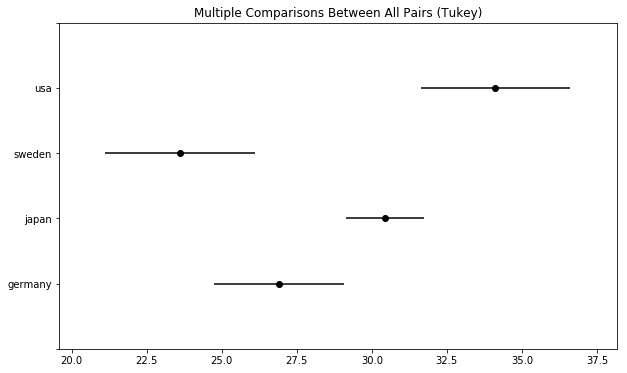

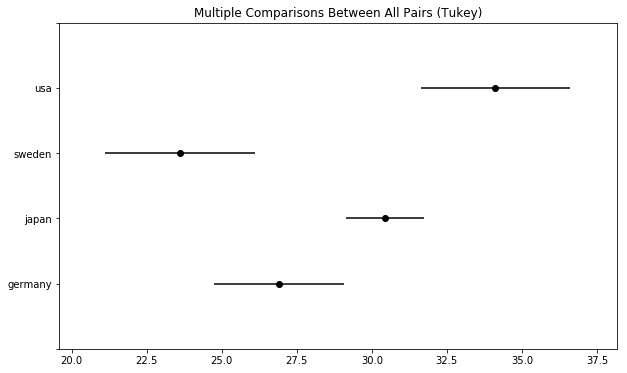

In [124]:
print('*'*20 + "MPG - Fuel Efficiency Analysis" + '*'*20)
pvar = 'mpg'


# MPG: Country of Origin: : ANOVA and Tukey HSD Difference of Means Tests; many categories so no bootstrap
print(20*'-'+ 'MPG: Country of Origin' + 20*'-')
groups, d = group_conditioned('make-origin', pvar) 
f_statistic, p_value = ss.f_oneway(*d)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

df = np.concatenate(d).flatten()
Tukey_HSD = pairwise_tukeyhsd(df, groups)
print(Tukey_HSD)
Tukey_HSD.plot_simultaneous()


The ANOVA and Tukey HSD results on MPG dependence on country of origin shows that there are statistically significant differences among some of the groups, with an ANOVA p-value on the order of 10^-7. Specifically, the Tukey HSD test and figures show us that in this dataset, the USA origin cars have significantly different mean than Sweden and Germany, but not Japan. Japan is stastically different than Sweden, but not Germany or USA. I'm honestly a bit suprised the American cars are most efficient in this dataset and Sweden is least efficient; I wasn't expecting that outcome. 


Next: The country of origin has multiple categories so it's tedious to do a lot of bootstrap tests on the different pair possibilities. Instead, let's use the Tukey plot above to guide us towards comparing just the sets that are plausabily overlapping one another: USA and Japan; Japan and Germany; Sweden and Germany. In each case the difference is between the higher value(s) and the lower value(s)

In [125]:
# Boostrap Method for some of the make-origin possibilities

japan_mpg = auto_price[auto_price.loc[:, 'make-origin'] == 'japan'].mpg
german_mpg = auto_price[auto_price.loc[:, 'make-origin'] == 'germany'].mpg
american_mpg = auto_price[auto_price.loc[:, 'make-origin'] == 'usa'].mpg
swedish_mpg = auto_price[auto_price.loc[:, 'make-origin'] == 'sweden'].mpg


bootstrap_diff_means = pd.Series([japan_mpg.sample(frac=1, replace=True).mean() - swedish_mpg.sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("Japan", "Sweden", "MPG",lower_ci, upper_ci))


bootstrap_diff_means = pd.Series([japan_mpg.sample(frac=1, replace=True).mean() - german_mpg.sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("Japan", "Germany", "MPG",lower_ci, upper_ci))

bootstrap_diff_means = pd.Series([american_mpg.sample(frac=1, replace=True).mean() - japan_mpg.sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("USA", "Japan", "MPG",lower_ci, upper_ci))

bootstrap_diff_means = pd.Series([german_mpg.sample(frac=1, replace=True).mean() - swedish_mpg.sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("Germany", "Sweden", "MPG",lower_ci, upper_ci))

bootstrap_diff_means = pd.Series([american_mpg.sample(frac=1, replace=True).mean() - japan_mpg.sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("America", "Japan", "MPG",lower_ci, upper_ci))

bootstrap_diff_means = pd.Series([american_mpg.sample(frac=1, replace=True).mean() - swedish_mpg.sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("America", "Swedish", "MPG",lower_ci, upper_ci))

bootstrap_diff_means = pd.Series([american_mpg.sample(frac=1, replace=True).mean() - german_mpg.sample(frac=1, replace=True).mean()
                             for i in range(n_replicas)])
lower_ci = np.percentile(bootstrap_diff_means, alpha/2.)
upper_ci = np.percentile(bootstrap_diff_means, 100-alpha/2.)
print("The CI on bootstrap diff ({} - {}) mean of {} is {:.2f}:{:.2f}".format("America", "Germany", "MPG",lower_ci, upper_ci))

The CI on bootstrap diff (Japan - Sweden) mean of MPG is 6.21:7.05
The CI on bootstrap diff (Japan - Germany) mean of MPG is 2.83:5.12
The CI on bootstrap diff (USA - Japan) mean of MPG is 0.93:6.92
The CI on bootstrap diff (Germany - Sweden) mean of MPG is 2.02:4.45
The CI on bootstrap diff (America - Japan) mean of MPG is 1.39:6.00
The CI on bootstrap diff (America - Swedish) mean of MPG is 8.03:12.47
The CI on bootstrap diff (America - Germany) mean of MPG is 3.34:11.40


The Tukey HSD test and figures showed us that in this dataset, the USA origin cars have significantly different mean than Sweden and Germany, but not Japan. Japan is stastically different than Sweden, but not Germany or USA. When we bootstrap the difference in means, we get pretty similar outcomes. Japan - Sweden is positive and does not span zero; we can reject the null hypothesis and conclude the Japanese cars are more efficient than Swedish cars. That is true for American cars relative to Swedish cars, and American cars relative to German cars (although that one is a bit less certain, it is possible to get a CI that includes zero depending on the sampling). Japan and Germany, Japan and USA pairs have bootstrapped differences with CI spanning 0.0 - they are not statistically different. Likewise with America - Japan. That is exactly what we expected from the Tukey results.

In [126]:
# Baysian CI for Japan, Germany, USA, and Sweden
# Fourth, Baysian test to see if CI on pair of variables overlap

print('-'*20+ "Bayes" + '-'*20)
vec = american_mpg
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("America")
print_ci(p, post) 

vec = japan_mpg
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Japan")
print_ci(p, post)

vec = german_mpg
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Germany")
print_ci(p, post)  

vec = swedish_mpg
p = np.linspace(min(vec), max(vec), num=N)
# create a prior
norm_prior = scipy.stats.norm.pdf(p, loc=vec.mean(), scale=5)
norm_prior = norm_prior / norm_prior.sum() # normalize
like = comp_like_gauss(p, vec)
post = posterior(norm_prior, like)
print("Sweden")
print_ci(p, post)  


--------------------Bayes--------------------
America
The 0.950 credible interval is 31.200 to 36.851
Japan
The 0.950 credible interval is 29.366 to 31.544
Germany
The 0.950 credible interval is 24.135 to 29.630
Sweden
The 0.950 credible interval is 22.576 to 24.686


The Baysian results agree completely with the Tukey and Bootstrap results. Ranked from most efficient to least efficient: American, Japanese, German, Swedish cars. American cars MPG have no overlap with German or Swedish, but a small overlap with Japanese. Japan has overlap with Germany but not with Sweden. Germany overlaps with Sweden, but just a little. 


** Conclusion**

In this milestone I have explored the distributions of MPG, price, and curb weight. I began by cleaning the dataset, determining that I could safely combine city-mpg and highway-mpg, and picking out a set of variables that we haven't delved into prior to this assignmnet, and which had a relationship with MPG. I recoded the manufacturer column into a country of origin column so we could get some insight into where cars came from, which a prior might be expected to make a difference based on different regulatory environments in different places. 

I fit distributions to these, then used classical, bootstrap, and Baysian methods to calculate statistics & confidence intervals on those statistics. The different methods had many of the same results, but we also saw how the bootstrap and Bayes methods resulted in tighter confidence intervals. However the bootstrap appraoch made it really easy to calculate CI on standard deviation, whereas the Bayes approach made that pretty difficult.

Then I performed hypothesis testing to explore the dependence of efficiency, represented by MPG, on engine type, number of cylinders, and country of origin. The engine type did not have a detectable effect on MPG, and ideally we would have more data to explore this relationship. Number of cylinders did have an effect: four cylinder cars were more fuel efficient than six cylinder cars, which matches our intuition about cars. Country of origin also had a noticeable, but obviously more complicated, relationship with MPG. There were detectable differences between some countries, but not between other. Surprisingly, American cars were most efficient and Swedish cars were least efficient. Japanese and German cars were in the middle. 

I also performed hypothesis testing to explore the dependence of price on engine type and number of cylinders. Engine type did not make a difference, but number of cylinders did. Four cylinder cars were generally more affordable than six cylinder cars. Apparently if you want an affordable, efficient car, buy an American 4-cylinder!

Each of these three variables had additional categories which were not included because they had fewer than 10 entries. If we had a much larger dataset, we could include those categories and seek additional insights. 

In the future, I would like to develop a regression model to determine how well we can predict fuel efficiency based on number of cylinders and country of origin, and possibly other variables. 